<b>Hyperparameters</b>: 
<br><b>win_tol</b>: window tolerance within which if a method detected cp, count that as true changepoint detected
<br>win_tol=2
<br>For BOCD: <b>run_length_threshold</b> - the change in run_length that constitutes a changepoint, for example if run_length_threshold is set to 4, then if run length drops by 4 or more, then that constitutes a changepoint
<br>For gradient based: <b>gradient_threshold</b>: the threshold above which a change in gradient constitutes a changepoint.
<br>For MC_dropout: <b>mc_dropout_threshold</b>: the threshold above which a change in variance in any of the output dimensions constitutes a changepoint
<br>
<br> <b>If TP=FP=0, Precision=1 rather than 0 and if TP=FN=0, then Recall=1 rather than 0 
<br> zero division is taken as 1 and not 0 for Precision and Recall</b>
<br> example: true_cps = [3, 31, 250, 273], pred_cps = [30, 31, 249, 250, 272, 300]
<br> TP = 3, FP = 1, FN = 1, TN = 317-5 = 312
<br> true changepoint 3 could not be detected but the rest were detected within the window tolerance
<br> false changepoint 300 was detected
<br>
<br>Precision = TP/(TP+FP)
<br>Recall or A_cp = TP/(TP+FN)
<br>A_cp = Accuracy for detecting changepoints (minority class)
<br>Accuracy = (TP+TN)/(TP+TN+FP+FN)
<br>A_major or A_no_cp = TN/(TN+FP)
<br>A_major or A_no_cp = Accuracy for detecting points that are not changepoints (majority class)
<br>Balanced_Accuracy = 1/2*(A_cp+A_major)

In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from   matplotlib.colors import LogNorm
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score, auc
from sklearn import metrics

In [2]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [3]:
os.chdir(os.environ.get('USER_PATH'))

In [4]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.labelUtil import nearestNeighbourMapping, repeat_pop_arr
from src.utils.decorators import timer
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.dataset import Haplotype
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred
import inference

# load the model and use valid data to choose hyperpparams for the different cp methods

In [5]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_pca')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_pca')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_Q_exp_id_1_data_id_1_pca/') 
dataset_type='test'

In [6]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
yaml_path = osp.join(config['models.dir'], 'params.yaml')
assert osp.isfile(yaml_path), "No json configuration file found at {}".format(yaml_path)
params = Params(yaml_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=1
params.balancedLoss=False
results, valid_dataset,_,_=inference.main(config, params)

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (564, 317410)
INFO: __init__:src.main.dataset: y_labels data :(564, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished 'mapping_func' in 0.3749 secs
Finished 'pop_mapping' in 0.1347 secs
Finished 'pop_mapping' in 0.1361 secs
Finished 'transform_data' in 31.9788 secs
Finished '__init__' in 86.8030 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
device in load model:None
Finished 'load_model' in 0.5280 secs
best val loss metrics : {'loss_main': 0.32982670098526423, 'loss_aux': 0.8378495132421891, 'gcd': None, 'mse': 0.17319945671879727, 'smooth_l1': 0.08350094807714122, 'weighted_loss': 0.32982670098526423}
at epoch : 131
train loss metrics: {'loss_main': 0.31123373579025687, 'loss_aux': 0.7249774828171883, 'gcd': None, 'mse': 0.09206160483954577, 'smooth_l1': 0.045924477757158993, 'weighted_loss': 0.31123373579025687}
best val cp metrics : {'loss_cp': 0.2588518878027973, 'prMetrics': OrderedDict([('Precision', array(0.36076843)), ('Reca

In [7]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [8]:
results.t_out.coord_main.shape

(2964, 317, 3)

In [9]:
results.t_accr, results.t_cp_accr

({'gcd': None,
  'loss_aux': 0.8373349999880266,
  'loss_main': 0.3766868721649808,
  'mse': 0.2077478971127172,
  'smooth_l1': 0.1003781191031335,
  'weighted_loss': 0.3766868721649808},
 {'loss_cp': 0.35382611108954803,
  'prMetrics': OrderedDict([('Precision', array(0.46692769)),
               ('Recall', array(0.70485412)),
               ('Accuracy', array(0.98138333)),
               ('A_major', array(0.98614461)),
               ('BalancedAccuracy', 0.8454993684875916)])})

In [10]:
@timer
def prMetricsByThresh(method_name, cp_pred_raw, cp_target, steps, minThresh, maxThresh, win_tol=2, byWindows=False):
    increment = (maxThresh - minThresh)/steps
    df=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
    for thresh in np.arange(minThresh, maxThresh + increment, increment):
        prMetrics, cp_pred = reportChangePointMetrics(method_name, cp_pred_raw, cp_target, thresh, win_tol)
        if byWindows: 
            prMetrics={}
            prMetrics['Precision']=precision_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Recall']=recall_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['BalancedAccuracy']=balanced_accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Accuracy']=accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['A_major']=(2*prMetrics['BalancedAccuracy'])-prMetrics['Recall']
        prMetrics['thresh']=thresh
        prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
        df=df.append(prMetrics, ignore_index=True)
    return df

# neural network, choose the threshold for logits

In [11]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        torch.tensor(valid_dataset.data['cps']).unsqueeze(2).float(), 20, 0, 0.85)
df_nn.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 13.5194 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.017489300120084983,1.0,0.049102372529236216,0.032729808029585875,0.516365,0.000000,0.034377
1,0.09517260069785562,0.8832369215291751,0.8558889640991584,0.855418086704977,0.869328,0.042500,0.171830
2,0.1070581072220314,0.8623616700201208,0.8759222127145089,0.876155698269105,0.869259,0.085000,0.190470
3,0.11141085983239582,0.8543133802816901,0.8821994320915124,0.882679574399903,0.868496,0.127500,0.197116
4,0.11400893558440242,0.8487801810865191,0.88579143198934,0.8864286920635196,0.867604,0.170000,0.201017
5,0.11591691026204827,0.8452590543259557,0.8882605993265134,0.8890010003421084,0.867130,0.212500,0.203875
6,0.32113113568808077,0.7540241448692153,0.9688554983673695,0.9725544666790807,0.863289,0.255000,0.450429
7,0.34580803362914525,0.7448440643863179,0.9718302064309038,0.9757384560087649,0.860291,0.297500,0.472329
8,0.3658992491977943,0.7384934607645876,0.9739109056309787,0.9779643254619546,0.858229,0.340000,0.489344
9,0.3832801867254019,0.7330860160965795,0.9755158644001414,0.9796900238609741,0.856388,0.382500,0.503378


In [12]:
nnThresh=0.8

# gradient method, choose the threshold for gradient difference in predictions

In [13]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        torch.tensor(valid_dataset.data['cps']).unsqueeze(2).float(), 20, 0,1)
df_grad.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 10.4105 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.017545582217887802,1.0,0.052206924737225255,0.035887814447365114,0.517944,0.000000,0.034486
1,0.06459388457059285,0.8997736418511066,0.7777515251365492,0.7756505471568199,0.837712,0.050000,0.120535
2,0.16272611464968154,0.8031941649899397,0.9267168163067216,0.9288436305056708,0.866019,0.100000,0.270624
3,0.2658541989807224,0.7544014084507042,0.9605805948990409,0.9641305901152342,0.859266,0.150000,0.393158
4,0.34575442883323154,0.7117706237424547,0.9723240398983384,0.9768102511248435,0.844290,0.200000,0.465422
5,0.4216222552160663,0.678508551307847,0.9788034755658863,0.9839739564613006,0.831241,0.250000,0.520073
6,0.4917381100627425,0.6455608651911469,0.9827062499733926,0.9885112224527003,0.817036,0.300000,0.558247
7,0.5606121859659255,0.6103495975855131,0.9853073900475527,0.9917634169261349,0.801057,0.350000,0.584425
8,0.6303429165223415,0.5721202213279678,0.987078379034215,0.994223132586469,0.783172,0.400000,0.599822
9,0.6911920475841278,0.5333878269617707,0.9880681745616163,0.9958968651616786,0.764642,0.450000,0.602122


In [14]:
gradThresh=0.5

# mc dropout variance, choose the threshold for difference in variance

In [15]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        torch.tensor(valid_dataset.data['cps']).unsqueeze(2).float(), 20, 0,0.5)
df_var.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 8.4498 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.017545582217887802,1.0,0.052206924737225255,0.035887814447365114,0.517944,0.000000,0.034486
1,0.07683167864364954,0.8456991951710262,0.8253894260037378,0.8250397322027879,0.835369,0.025000,0.140866
2,0.1930013821933048,0.7199446680080482,0.9443053763990175,0.9481684212349678,0.834057,0.050000,0.304400
3,0.31494037064079833,0.5695422535211268,0.9717439984333559,0.9786691119473759,0.774106,0.075000,0.405597
4,0.37051922659135345,0.42894869215291753,0.977998867588773,0.9874524187925741,0.708201,0.100000,0.397599
5,0.39109811052257093,0.31105382293762573,0.9801412959722772,0.9916616505211739,0.651358,0.125000,0.346514
6,0.3927236755330842,0.22466046277665996,0.9809959258738936,0.9940185171552176,0.609339,0.150000,0.285817
7,0.3860045146726862,0.16128018108651912,0.9814610233421457,0.9955829049761606,0.578432,0.175000,0.227505
8,0.3674296131253798,0.11405935613682093,0.9816802683729464,0.99661897358837,0.555339,0.200000,0.174080
9,0.33262599469496024,0.07884808853118712,0.9817302902974495,0.997276124735299,0.538062,0.225000,0.127478


In [16]:
varThresh=0.1

# BOCD, Compute the run lengths and changepoints by using a multivariate Gaussian (with independent three dimensions of predictions) to model the prediction sequence

In [17]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, _, predictive, e_mean = model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 155.4058 secs


In [18]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        torch.tensor(valid_dataset.data['cps']).unsqueeze(2).float(), 20,1,10)
df_bocd.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 17.2997 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.6403653571035546,0.3658827967806841,0.9857884519597951,0.996461993495611,0.681172,1.000000,0.465688
1,0.6403653571035546,0.3658827967806841,0.9857884519597951,0.996461993495611,0.681172,1.450000,0.465688
2,0.6403653571035546,0.3658827967806841,0.9857884519597951,0.996461993495611,0.681172,1.900000,0.465688
3,0.6394975766263908,0.5890342052313883,0.9874232110244064,0.9942826767595845,0.791658,2.350000,0.613229
4,0.6394975766263908,0.5890342052313883,0.9874232110244064,0.9942826767595845,0.791658,2.800000,0.613229
5,0.6168561631474463,0.6447434607645876,0.9872082231786699,0.9931047847532273,0.818924,3.250000,0.630492
6,0.6168561631474463,0.6447434607645876,0.9872082231786699,0.9931047847532273,0.818924,3.700000,0.630492
7,0.5974782313694448,0.6644240442655935,0.9867431257104178,0.992292818756198,0.828358,4.150000,0.629175
8,0.5974782313694448,0.6644240442655935,0.9867431257104178,0.992292818756198,0.828358,4.600000,0.629175
9,0.5811965811965812,0.6712776659959758,0.9862482279467171,0.9916713941131382,0.831475,5.050000,0.622998


In [19]:
bocdThresh=3.0

# Summary Table with chosen thresholds

In [20]:
pd.options.display.float_format='{:,.4f}'.format
df_summary=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
cpThresh=[nnThresh, gradThresh, bocdThresh, varThresh]
cp_target=valid_dataset.data['cps']
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             model_cpd.cp,  torch.tensor(results.t_out.y_var).float()]
for name, thresh, pred_raw in zip(['neural_network', 'gradient', 'BOCD', 'mc_dropout'], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, cp_target, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary=df_summary.append(prMetrics, ignore_index=True)
df_summary

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.6582070100829961,0.6033702213279678,0.9879830308603346,0.9946052979157374,0.7990,0.8000,0.6296,neural_network
1,0.7384093479080287,0.4927062374245473,0.9884587712912468,0.9969946431896622,0.7449,0.5000,0.5910,gradient
2,0.6168561631474463,0.6447434607645876,0.9872082231786699,0.9931047847532273,0.8189,3.0000,0.6305,BOCD
3,0.37051922659135345,0.42894869215291753,0.977998867588773,0.9874524187925741,0.7082,0.1000,0.3976,mc_dropout


plot of Precision/Recall

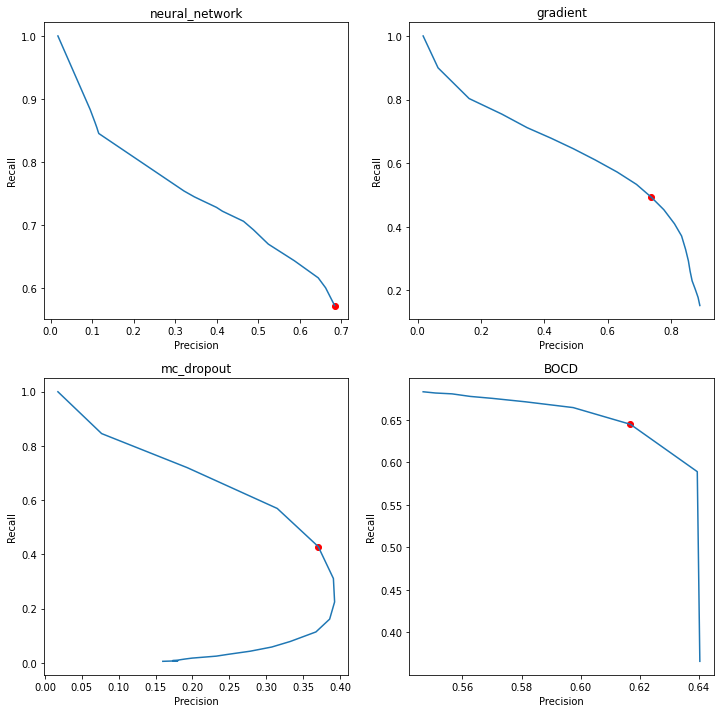

In [41]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    ax[row,col].plot(df['Precision'], df['Recall'])
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
    df_row=df_summary[df_summary.Name==name]
    ax[row,col].scatter(df_row['Precision'], df_row['Recall'], color='r')
plt.show()

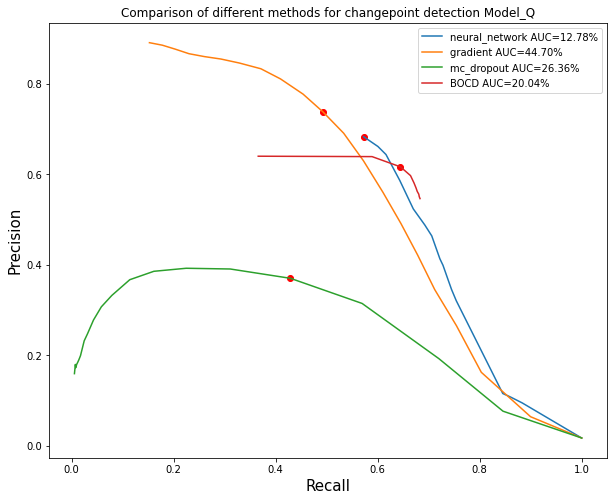

In [42]:
fig, ax = plt.subplots(figsize=[10,8])

for df, name in zip([df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    aucScore = "N/A"
#     if name!="BOCD":
    aucScore = format(auc(df['Recall'], df['Precision'])*100, ".2f")
    plt.plot(df['Recall'], df['Precision'], label=str(name) + " AUC="+ str(aucScore)+"%")
    plt.ylabel('Precision', fontsize=15)
    plt.xlabel('Recall', fontsize=15)
    plt.title(f"Comparison of different methods for changepoint detection {params.model}")
    df_row=df_summary[df_summary.Name==name]
    plt.scatter(df_row['Recall'], df_row['Precision'], color='r')
    plt.legend(loc="best")
plt.show()

# Qualitative by looking at anecdotes/samples

In [49]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
cp_target=valid_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             model_cpd.cp, torch.tensor(results.t_out.y_var).float()]
pred_cps = {}
for name, thresh, pred_raw in zip(['neural_network', 'gradient', 'BOCD', 'mc_dropout'], cpThresh, cp_pred_raw):
    _, pred_cps[name]= reportChangePointMetrics(name, pred_raw, cp_target, thresh)

true_cps=cp_target
pred_cps={k:v.detach().cpu().numpy() for k,v in pred_cps.items()}

In [50]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, popNames, y_var):
    fig, ax = plt.subplots(7,1,figsize=[18,30])
    ax[0].plot(y_pred)
    ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=10, zorder=5)
    ax[1].plot(pred_cps[cpMethod.gradient.name])
    ax[2].plot(y_var)
    ax[3].plot(pred_cps[cpMethod.mc_dropout.name])
    ax[4].plot(pred_cps[cpMethod.neural_network.name])
    ax[5].plot(np.arange(T+1), bocp_rl)
    ax[6].plot(pred_cps[cpMethod.BOCD.name])
    for i in np.nonzero(true_cps)[0]:
        for j in [0,1,2,3,4,5,6]:
            ax[j].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' , zorder=5)
            
            
    ax[0].set_title("n_vectors")
    ax[1].set_title("Simple gradient(post_process)")
    ax[2].set_title("Mc dropout variance")
    ax[3].set_title("Mc dropout")
    ax[4].set_title("Neural Network predicted cp")
    ax[5].set_title("BOCD (post process) run_length")
    ax[6].set_title("BOCD (post process) cp")
    plt.show()

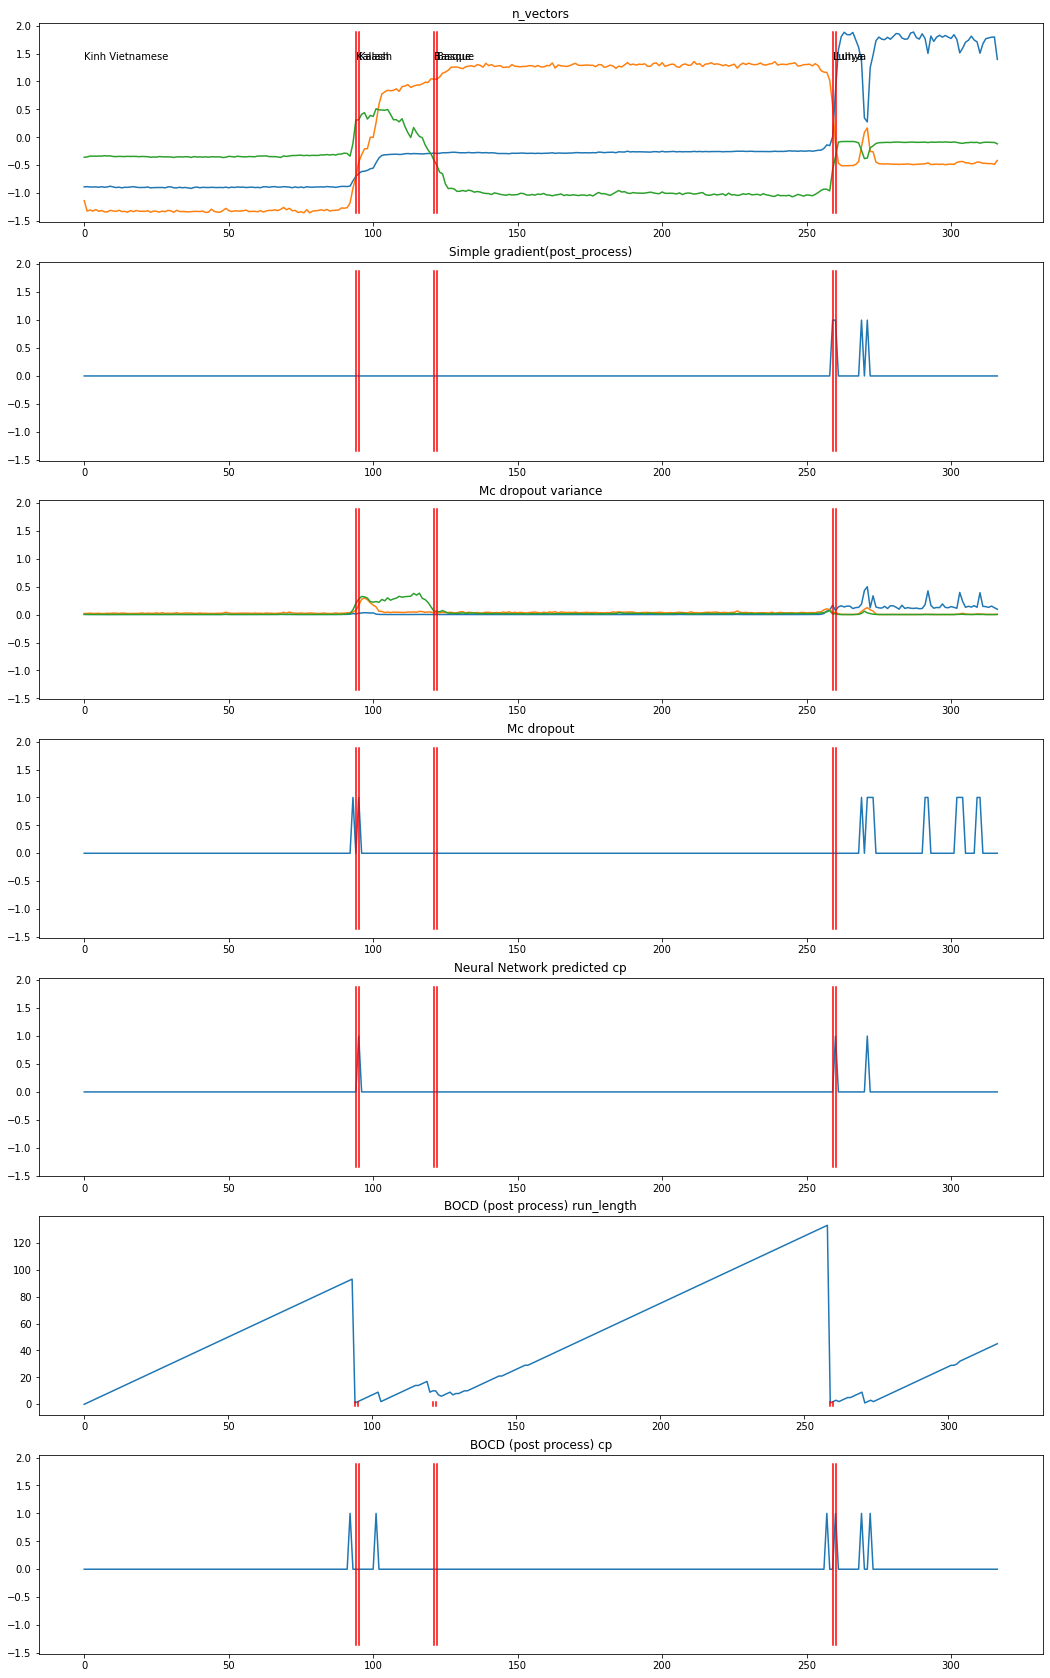

In [53]:
index = 1541
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, namesSample, y_varSample)

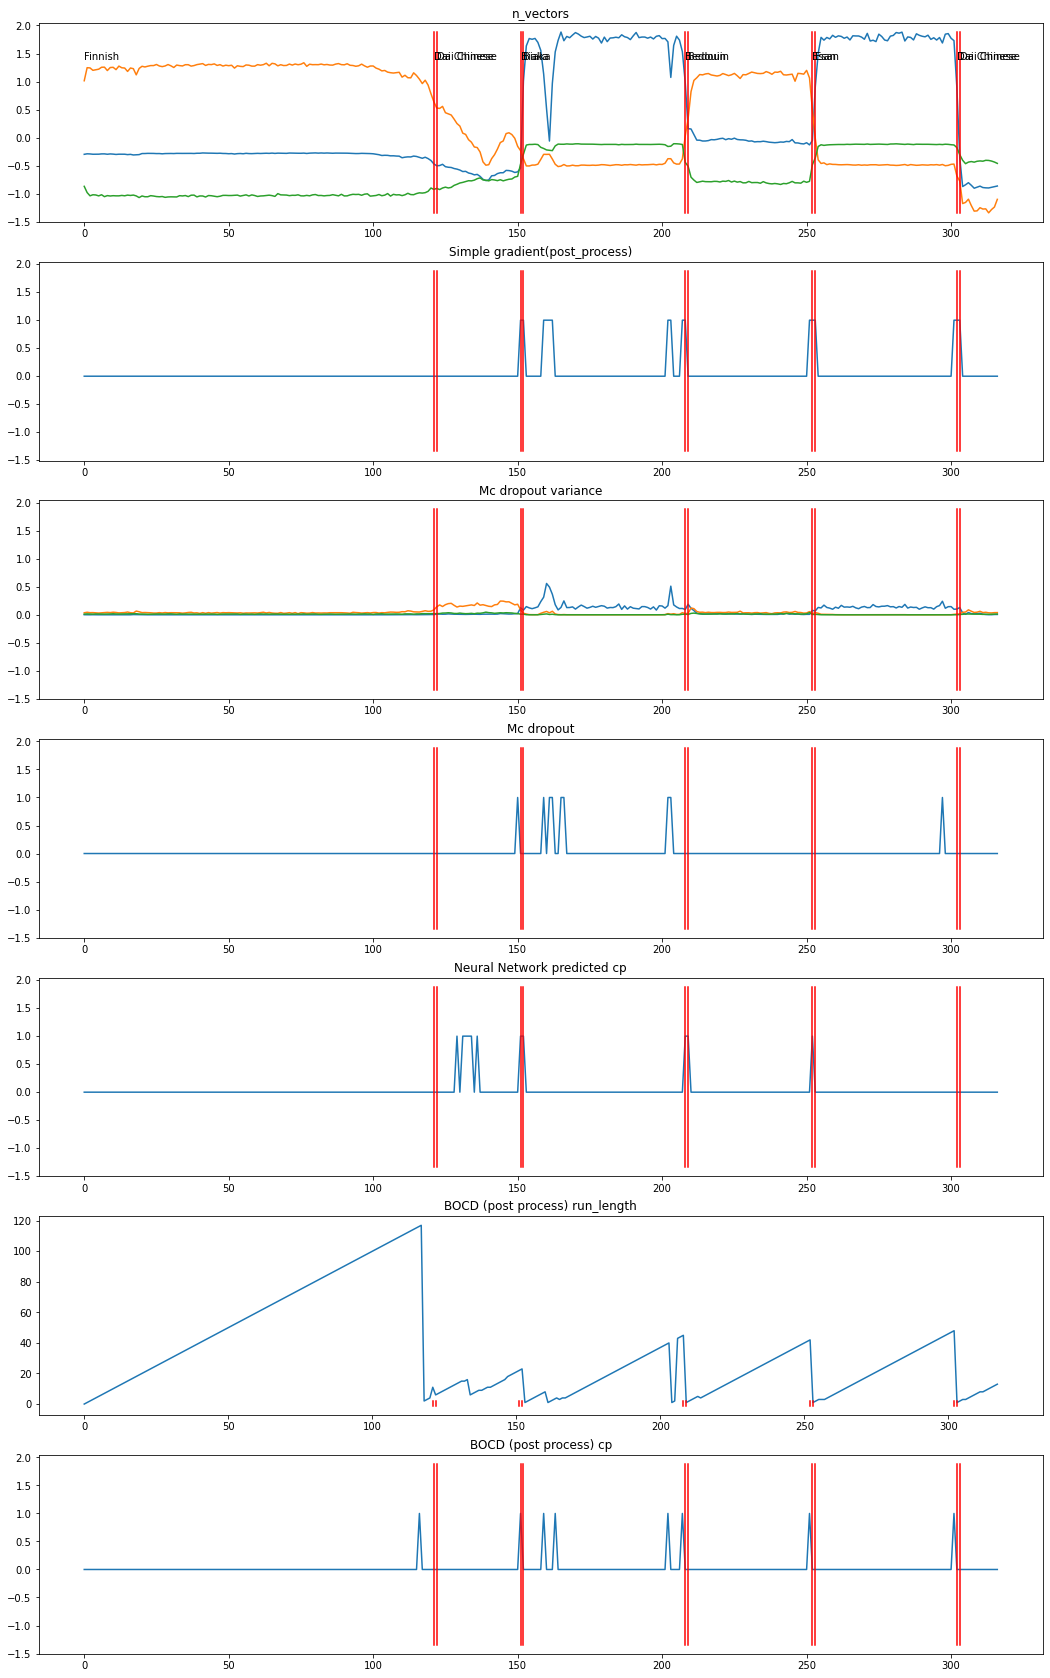

In [52]:
index = 2285
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, namesSample, y_varSample)

# evaluate on a subset of samples that have at least 1 changepoint 


In [29]:
subset_idx=np.unique(np.nonzero(valid_dataset.data['cps'])[0])

In [30]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'][..., np.newaxis][subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in double_scalars



,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.34971135343168697,0.6902139511330548,0.981560466578071,0.9849718797157435,0.8376,0.6500,0.4642,neural_network
1,0.1704927371119339,0.7578174452462337,0.954524608755152,0.9568278777708931,0.8573,0.1500,0.2784,gradient
2,0.0,0.0,0.9884263905840431,1.0,0.5000,4.0000,nan,mc_dropout
3,0.0,0.0,0.9884263905840431,1.0,0.5000,0.0250,nan,BOCD


# compute metrics by placing win_tol=0

In [31]:
df_zero_tol=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=valid_dataset.data['cps'][..., np.newaxis]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_zero_tol=df_zero_tol.append(prMetrics, ignore_index=True)
df_zero_tol

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in double_scalars



,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.15660725261216965,0.48385871629320165,0.9786871786007519,0.9820885157825212,0.7330,0.6500,0.2366,neural_network
1,0.09407246145949485,0.6728699835422205,0.9535300980942916,0.9554592912506712,0.8142,0.1500,0.1651,gradient
2,0.0,0.0,0.9931731558705328,1.0,0.5000,4.0000,nan,mc_dropout
3,0.0,0.0,0.9931731558705328,1.0,0.5000,0.0250,nan,BOCD


# evaluate to make sure matches with scikit learn (subset with samples that have cp, and win_tol=0 for evaluation

In [32]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'][..., np.newaxis][subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in double_scalars



,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.16600069492703265,0.48385871629320165,0.965891625067216,0.9715358092623503,0.7277,0.6500,0.2472,neural_network
1,0.10477241814346823,0.6728699835422205,0.9296733631159515,0.9326803063139452,0.8028,0.1500,0.1813,gradient
2,0.0,0.0,0.9884263905840431,1.0,0.5000,4.0000,nan,mc_dropout
3,0.0,0.0,0.9884263905840431,1.0,0.5000,0.0250,nan,BOCD


# evaluate by Windows

In [33]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        valid_dataset.data['cps'][..., np.newaxis], 20, 0.4, 0.5, byWindows=True)
df_nn.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 83.5419 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.130465,0.585897,0.970515,0.973158,0.779528,0.400000,0.213410
1,0.131074,0.585011,0.970691,0.973342,0.779176,0.405000,0.214163
2,0.131631,0.584251,0.970849,0.973507,0.778879,0.410000,0.214856
3,0.132175,0.583618,0.970998,0.973661,0.778639,0.415000,0.215536
4,0.132753,0.583112,0.971148,0.973815,0.778464,0.420000,0.216270
5,0.133287,0.582099,0.971306,0.973982,0.778040,0.425000,0.216907
6,0.133661,0.580960,0.971433,0.974117,0.777538,0.430000,0.217323
7,0.134087,0.579820,0.971569,0.974262,0.777041,0.435000,0.217805
8,0.134837,0.579567,0.971743,0.974439,0.777003,0.440000,0.218776
9,0.135330,0.578807,0.971878,0.974579,0.776693,0.445000,0.219370


In [34]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        valid_dataset.data['cps'][..., np.newaxis], 20, 0,1, byWindows=True)
df_grad.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 91.6387 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006848,1.000000,0.009981,0.003176,0.501588,0.000000,0.013604
1,0.023319,0.817445,0.765016,0.764656,0.791051,0.050000,0.045344
2,0.059035,0.729333,0.918791,0.920093,0.824713,0.100000,0.109229
3,0.094072,0.672870,0.953530,0.955459,0.814165,0.150000,0.165067
4,0.120747,0.625902,0.966332,0.968672,0.797287,0.200000,0.202440
5,0.145430,0.580580,0.973846,0.976550,0.778565,0.250000,0.232597
6,0.168320,0.534751,0.978786,0.981838,0.758295,0.300000,0.256047
7,0.194371,0.492214,0.982606,0.985977,0.739095,0.350000,0.278690
8,0.224336,0.450943,0.985607,0.989283,0.720113,0.400000,0.299617
9,0.256595,0.410052,0.987862,0.991834,0.700943,0.450000,0.315661


In [35]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        valid_dataset.data['cps'][..., np.newaxis], 20, 0,0.5, byWindows=True)
df_var.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 90.2532 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006848,1.000000,0.009981,0.003176,0.501588,0.000000,0.013604
1,0.022075,0.597417,0.816571,0.818078,0.707748,0.025000,0.042576
2,0.044394,0.370806,0.941213,0.945134,0.657970,0.050000,0.079294
3,0.066219,0.242309,0.971501,0.976513,0.609411,0.075000,0.104013
4,0.072462,0.156602,0.980557,0.986221,0.571412,0.100000,0.099079
5,0.073488,0.104570,0.984887,0.990938,0.547754,0.125000,0.086316
6,0.072495,0.071275,0.987434,0.993732,0.532503,0.150000,0.071880
7,0.068836,0.048740,0.989005,0.995468,0.522104,0.175000,0.057071
8,0.060120,0.031776,0.989999,0.996585,0.514181,0.200000,0.041577
9,0.054037,0.022281,0.990662,0.997319,0.509800,0.225000,0.031553


In [36]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        valid_dataset.data['cps'][..., np.newaxis], 20,1,11, byWindows=True)
df_bocd.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 105.7467 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.124361,0.117103,0.988344,0.994332,0.555718,1.000000,0.120623
1,0.124361,0.117103,0.988344,0.994332,0.555718,1.500000,0.120623
2,0.119176,0.184580,0.985120,0.990623,0.587601,2.000000,0.144837
3,0.119176,0.184580,0.985120,0.990623,0.587601,2.500000,0.144837
4,0.109521,0.195721,0.983645,0.989061,0.592391,3.000000,0.140450
5,0.109521,0.195721,0.983645,0.989061,0.592391,3.500000,0.140450
6,0.104827,0.201798,0.982786,0.988155,0.594976,4.000000,0.137979
7,0.104827,0.201798,0.982786,0.988155,0.594976,4.500000,0.137979
8,0.101669,0.204330,0.982243,0.987590,0.595960,5.000000,0.135779
9,0.101669,0.204330,0.982243,0.987590,0.595960,5.500000,0.135779


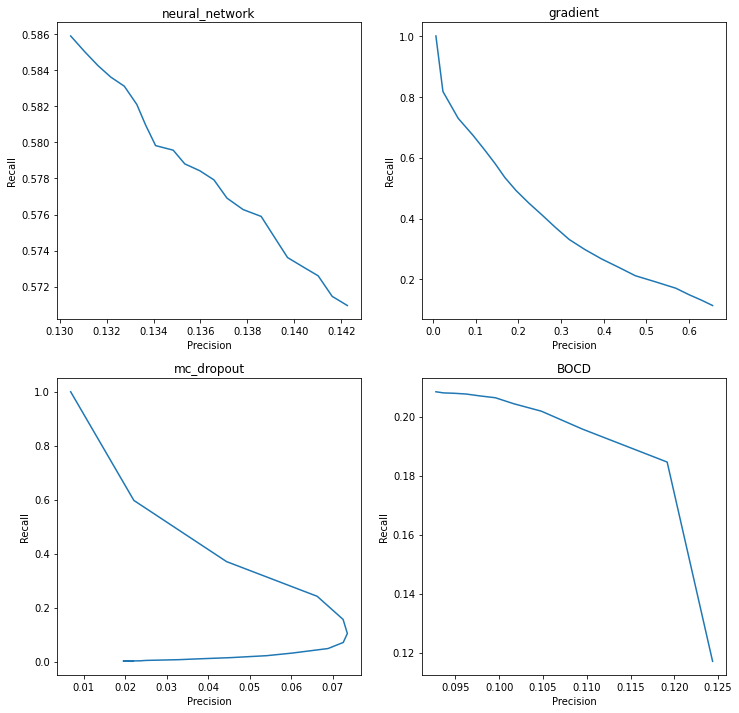

In [37]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    ax[row,col].plot(df['Precision'], df['Recall'])
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
plt.show()

# load the model and evaluate with test data on the chosen hyperparameters

In [38]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_4_geo')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_4_geo')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_Q_exp_id_3_data_id_4_geo/') 
dataset_type='test'

In [39]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=False
json_path = osp.join(config['models.dir'], 'params.yaml')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
results, test_dataset,_,_=inference.main(config, params)
results.t_out.coord_main=results.t_out.coord_main.mean(0)

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (540, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(540, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0665 secs
Finished 'mapping_func' in 0.2759 secs
Finished 'pop_mapping' in 0.1103 secs
Finished 'pop_mapping' in 0.1089 secs
Finished 'transform_data' in 33.7295 secs
Finished '__init__' in 40.4368 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
device in load model:None
Finished 'load_model' in 0.1856 secs
best val loss metrics : {'loss_main': 870.9366320208127, 'loss_aux': 2159.4718245838935, 'l1_loss': 0.20176482126010942, 'mse': 0.04551312713889611, 'smooth_l1': 0.022700810348433586, 'weighted_loss': 0.20176482126010942}
at epoch : 299
train loss metrics: {'loss_main': 250.43061244635055, 'loss_aux': 1543.2047426592148, 'l1_loss': 0.05562154084609267, 'mse': 0.004964988799775602, 'smooth_l1': 0.0024777479588382533, 'weighted_loss': 0.05562154084609267}
best val cp metrics : {'loss_cp'

# Summary Table with test data

compute BOCD

In [40]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
test_tensor = torch.tensor(y_pred).float()
batch_size_cpd = test_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, _, predictive, e_mean = model_cpd.run_recursive(test_tensor, 'cpu')

Finished 'run_recursive' in 172.3575 secs


In [41]:
df_test=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=test_dataset.data['cps']
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_test=df_test.append(prMetrics, ignore_index=True)
df_test

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in double_scalars



,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.028968555430950973,0.9137821731963991,0.7400587995450546,0.7385760956959959,0.8262,0.6500,0.0562,neural_network
1,0.6628304821150856,0.5403829085837454,0.993784201377712,0.9976539157855324,0.7690,0.1500,0.5954,gradient
2,0.0,0.0,0.9915373720466104,1.0,0.5000,4.0000,nan,mc_dropout
3,0.0,0.0,0.9915373720466104,1.0,0.5000,0.0250,nan,BOCD
